# Localización de objetos en una escena

In [1]:
# Importa la función para la representación de las imágenes
import sys  
sys.path.insert(0, '../')

import resources as src

In [2]:
path_box = "../data/box.png"
path_box_scene = "../data/box_in_scene.png"

Este código realiza una búsqueda de imagen utilizando el algoritmo SIFT (Scale-Invariant Feature Transform) y el algoritmo de emparejamiento de vecinos más cercanos basado en índices FLANN (Fast Library for Approximate Nearest Neighbors).

La imagen de consulta es "box.png" y la imagen de entrenamiento es "box_in_scene.png". Primero, se detectan y extraen los puntos clave y sus descriptores de ambas imágenes utilizando el detector SIFT. Luego, se crea un objeto "flann" utilizando los parámetros de índice y búsqueda especificados. Finalmente, se utiliza el objeto "flann" para encontrar parejas de puntos clave coincidentes entre las dos imágenes utilizando el método "knnMatch".

Luego, se aplica una prueba de relación de Lowe a cada par de coincidencias para filtrar las "buenas" coincidencias. La prueba de relación de Lowe consiste en mantener solo aquellas coincidencias cuya distancia es menor que un cierto porcentaje (0,7 en este caso) de la distancia del segundo mejor vecino más cercano. Esto se hace para eliminar las coincidencias que son menos confiables.

In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

box = cv.imread(path_box, 0)
box_scene = cv.imread(path_box_scene, 0)

In [4]:
MIN_MATCH_COUNT = 10

# Inicia el detector SIFT
sift = cv.SIFT_create()

# Encuentra los puntos clave y los descriptores
kp1, des1 = sift.detectAndCompute(box,None)
kp2, des2 = sift.detectAndCompute(box_scene,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Almacena las coincidencias dentro del radio.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

Si se encuentran suficientes coincidencias "buenas" (es decir, si hay más de MIN_MATCH_COUNT coincidencias), entonces el código procede a calcular la homografía entre las dos imágenes. La homografía es una transformación que se aplica a una imagen para hacerla coincidir con otra imagen vista desde una perspectiva diferente.

Para calcular la homografía, se utiliza el método "findHomography" de OpenCV. Esta función toma como entrada dos conjuntos de puntos, src_pts y dst_pts, que son correspondencias entre puntos clave en la imagen de consulta y la imagen de entrenamiento. También se proporciona el método de estimación RANSAC (RANdom SAmple Consensus) para eliminar las correspondencias erróneas.

Una vez que se ha calculado la homografía, se aplica a la imagen de entrenamiento para dibujar un cuadrilátero alrededor de la región de la imagen de entrenamiento que coincide con la imagen de consulta. Esto se hace utilizando la función "perspectiveTransform" de OpenCV. Por último, se dibuja el cuadrilátero en la imagen de entrenamiento utilizando la función "polylines".

Si no se encuentran suficientes coincidencias "buenas", se imprime un mensaje de error y se establece la variable "matchesMask" como "None".

In [5]:
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = box.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(box_scene, [np.int32(dst)], True, 3, 3, cv.LINE_AA)
else:
    print( "No se encontraron suficientes coincidencias - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


Esta última parte del código se utiliza para dibujar las coincidencias encontradas en una imagen y mostrarla. Se crea un diccionario "draw_params" con los parámetros de dibujo para la función "drawMatches" de OpenCV. Estos parámetros incluyen el color en el que se deben dibujar las coincidencias (verde), si se deben dibujar todas las coincidencias o solo las inliers (matchesMask), y el estilo de dibujo de las líneas que unen las correspondencias (FLAGS_DRAW_RICH_KEYPOINTS).

Luego se llama a la función "drawMatches" con las imágenes de consulta y de entrenamiento, los puntos clave y sus descriptores, y la lista de coincidencias "buenas" como argumentos. Esto devuelve una imagen con las coincidencias dibujadas. Por último, Se muestra la imagen en pantalla.

In [6]:
draw_params = dict(matchColor = (0,255,0), # Dibuja las coincidencias
                   singlePointColor = None,
                   matchesMask = matchesMask, # Dibuja solo los inliers
                   flags = 2)
img3 = cv.drawMatches(box, kp1, box_scene, kp2, good, None, **draw_params)

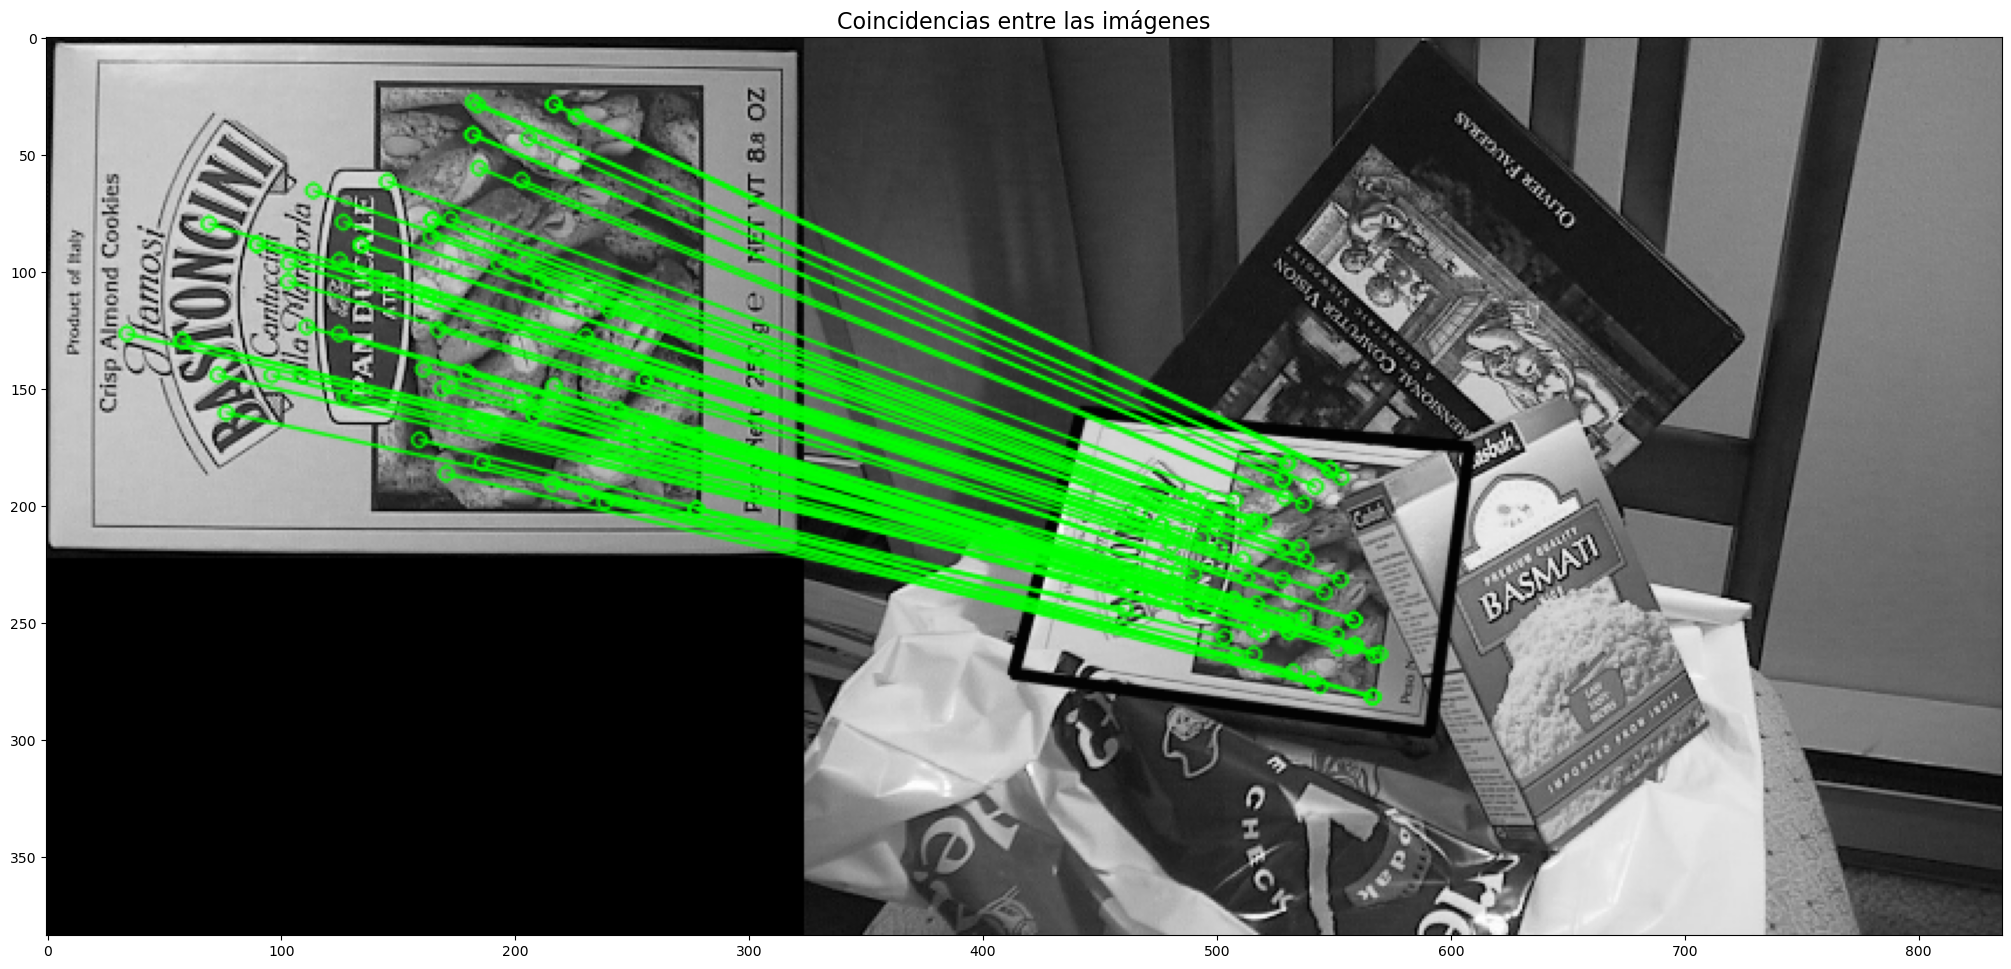

In [7]:
# Muestra las imágenes 
src.mostrar_imagenes(1, 1, ['Coincidencias entre las imágenes'], [img3], 20, 14, (False, 0))

Para calcular la posición del cuadrilátero, se calcula la media de las coordenadas x e y de los puntos de destino "dst". Con lo que se obtiene un punto central aproximado para el cuadrilátero en la imagen de entrenamiento.

In [8]:
# Vector de coordenadas de los puntos que muestran las esquinas del cuadrilátero
dst

array([[[118.79797, 160.89099]],

       [[ 89.65635, 272.0471 ]],

       [[267.45065, 297.9469 ]],

       [[284.19675, 175.06491]]], dtype=float32)

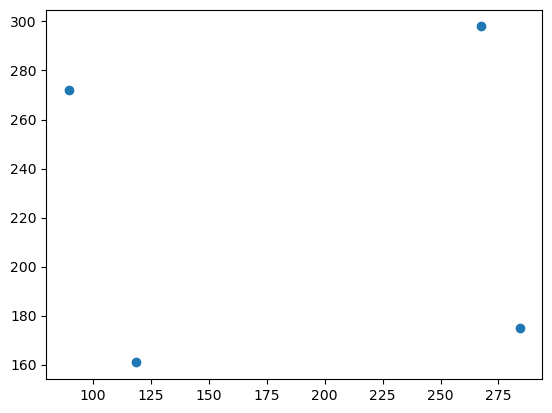

In [9]:
import matplotlib.pyplot as plt

# Se estran las coordenadas de los puntos
x = dst[:,:,0]
y = dst[:,:,1]

# Se muestran en pantalla
plt.scatter(x, y)
plt.show()


In [10]:
x_pos = np.mean(dst[:,:,0])
y_pos = np.mean(dst[:,:,1])

print (f'La posición se encuentra en el punto ({x_pos}, {y_pos})')

La posición se encuentra en el punto (190.02542114257812, 226.48748779296875)


Para calcular la orientación del cuadrilátero, se calcula el ángulo entre dos de los lados del cuadrilátero y se le restan 90 grados para obtener el ángulo con respecto a la transformación horizontal:

In [11]:
dx = dst[2][0][0] - dst[3][0][0]
dy = dst[2][0][1] - dst[3][0][1]
angle = np.arctan2(dy, dx) * 180 / np.pi

print (f'El ángulo de orientación es ({angle - 90})')

El ángulo de orientación es (7.760337829589844)


Este cálculo utiliza la función "arctan2" de NumPy para calcular el ángulo en radianes y luego lo convierte a grados utilizando la constante pi. Lo que da el ángulo en grados entre el lado derecho e inferior del cuadrilátero en la imagen de entrenamiento. Si se necesita calcular el ángulo entre otros lados del cuadrilátero, hay que cambiar los índices de los puntos de destino "dst" que se utilizan para calcular dx y dy.

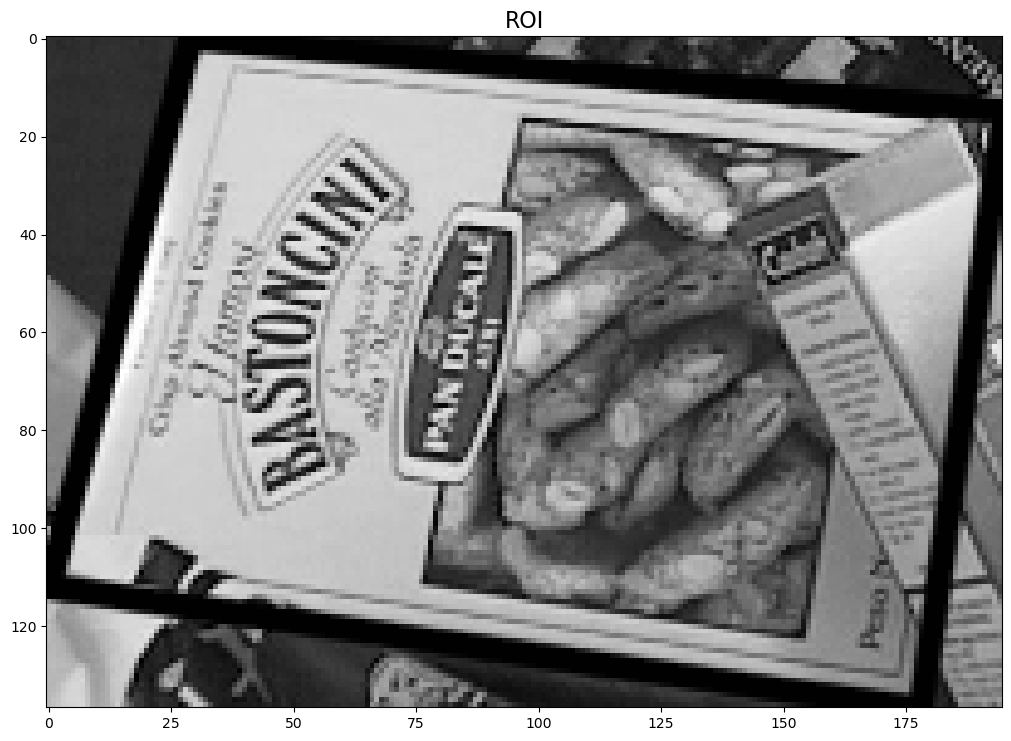

In [12]:
# Obtener las dimensiones de la imagen
height, width = img2.shape[:2]

# Definir el ROI a extraer
x1 = int(89.832504)
y1 = int(160.96033)
x2 = int(284.3881)
y2 = int(297.9169 )
roi = box_scene[y1:y2, x1:x2]

# Mostrar el ROI extraído
src.mostrar_imagenes(1, 1, ['ROI'], [roi], 10, 10, (True, 0))
